# Training a neural network with McSnow selfcollection output

This script applies a DNN to the regression problem compare with Seifert and Beheng (2001)

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


### Load Tensorflow and other useful modules

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0


In [2]:
tf.random.set_seed(1234)

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=str(4)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
# mdir='/Users/axel/DWD/GITLAB/mcsnow/'
# edir='experiments/'
mdir='../data/'
edir=''

data="big_n5"
fname1=mdir+edir+'autocon_train_'+data+'.nc'
fname2=mdir+edir+'autocon_test_'+data+'.nc'
fname3=mdir+edir+'autocon_val_big_n2.nc'

ds1 = xr.open_dataset(fname1)
ds2 = xr.open_dataset(fname2)
ds3 = xr.open_dataset(fname3)

print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:     (i: 6, ii: 6, j: 7, jj: 7, k: 5, kk: 5, n: 5, nn: 5, nt: 4000)
Coordinates:
  * n           (n) int32 0 1 2 3 4
  * i           (i) int32 200 400 600 800 1000 2000
  * j           (j) int32 9 10 11 12 13 14 15
  * k           (k) int32 0 1 2 3 4
Dimensions without coordinates: ii, jj, kk, nn, nt
Data variables:
    time        (n, i, j, k, nt) float32 ...
    tau         (n, i, j, k, nt) float32 ...
    Lc          (n, i, j, k, nt) float32 ...
    Nc          (n, i, j, k, nt) float32 ...
    Zc          (n, i, j, k, nt) float32 ...
    Lr          (n, i, j, k, nt) float32 ...
    Nr          (n, i, j, k, nt) float32 ...
    Zr          (n, i, j, k, nt) float32 ...
    nu          (n, i, j, k, nt) float32 ...
    mue         (n, i, j, k, nt) float64 ...
    nue         (n, i, j, k, nt) float64 ...
    auto_num    (n, i, j, k, nt) float32 ...
    auto_mass   (n, i, j, k, nt) float32 ...
    accr_num    (n, i, j, k, nt) float32 ...
    accr_mass   (n

# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    self = xr.open_dataset(fname).self_rain.values
    Lr   = xr.open_dataset(fname).Lr.values
    Nr   = xr.open_dataset(fname).Nr.values
    tau  = xr.open_dataset(fname).tau.values
    # transform everything except nu in log space
    L_min = 1e-15
    N_min = 1e-15
    tau_min  = 1e-15
    self_min = 1e-15
    Xr = np.log(Lr/Nr, where=Nr>N_min)
    Nr = np.log(Nr, where=Nr>N_min)
    Lr = np.log(Lr, where=Lr>L_min)
    tau = np.log(tau, where=tau>tau_min, out=np.nan*tau)    
    self = np.log(self, where=self>self_min, out=np.nan*self)
    # put everything in a pandas dataframe    
    dataset = pd.DataFrame(np.array( [ self.ravel(), Lr.ravel(), Nr.ravel(), Xr.ravel(), tau.ravel() ]))
    dataset = dataset.T
    dataset.columns = [ 'self','Lr','Nr','Xr','tau' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
dataset_train = read_and_prepare_data(fname1)
dataset_test  = read_and_prepare_data(fname2)
dataset_val   = read_and_prepare_data(fname3)

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


### Inspect the data

In [8]:
dataset_train.describe()

self             Lr             Nr             Xr  \
count  310587.000000  310587.000000  310587.000000  310587.000000   
mean       -1.767209      -9.297490       6.942675     -16.239719   
std         4.601111       2.198887       2.429914       3.536855   
min       -17.727533     -20.693756       0.919470     -22.034079   
25%        -3.806110     -10.324216       5.107472     -19.582408   
50%        -0.969386      -8.536218       7.165293     -16.288519   
75%         1.355900      -7.830205       8.801203     -13.089259   
max         8.206409      -6.216760      13.366846      -9.336143   

                 tau  
count  310587.000000  
mean       -1.470034  
std         2.139591  
min       -13.163157  
25%        -2.451887  
50%        -0.193865  
75%        -0.011250  
max        -0.001000

In [9]:
dataset_test.describe()

self             Lr             Nr             Xr  \
count  182110.000000  182110.000000  182110.000000  182110.000000   
mean       -1.406297      -9.135769       7.130118     -16.266850   
std         4.606367       2.269733       2.357029       3.559133   
min       -17.727533     -21.184254      -1.062256     -22.032505   
25%        -3.334113     -10.259103       5.335771     -19.648931   
50%        -0.521679      -8.138966       7.335745     -16.336814   
75%         1.732861      -7.606929       8.947628     -13.072179   
max         7.404851      -6.504506      12.864232      -9.635016   

                 tau  
count  182110.000000  
mean       -1.561345  
std         2.235588  
min       -13.147753  
25%        -2.661926  
50%        -0.215910  
75%        -0.011753  
max        -0.001001

In [10]:
dataset_val.describe()

self             Lr             Nr             Xr  \
count  123656.000000  123656.000000  123656.000000  123656.000000   
mean       -1.757874      -9.299753       6.955914     -16.257015   
std         4.601688       2.209243       2.411839       3.533613   
min       -17.727533     -19.725365       1.418403     -21.991121   
25%        -3.796029     -10.342915       5.126404     -19.614141   
50%        -0.933792      -8.536167       7.162018     -16.301448   
75%         1.347394      -7.829966       8.798899     -13.111253   
max         8.147251      -6.216795      13.302092      -9.433998   

                 tau  
count  123656.000000  
mean       -1.477224  
std         2.143349  
min       -12.305305  
25%        -2.472877  
50%        -0.196278  
75%        -0.011318  
max        -0.001000

### Reduce the data

In [11]:
def reduce_data(dataset):
    idx = dataset[ dataset['Lr'] < np.log(1e-7) ].index
    dataset.drop(idx,inplace=True)
#    idx = dataset[ dataset['tau'] > np.log(0.95) ].index
#    dataset.drop(idx,inplace=True)
    return dataset

In [12]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

In [13]:
dataset_train.describe()

self             Lr             Nr             Xr  \
count  309151.000000  309151.000000  309151.000000  309151.000000   
mean       -1.703866      -9.263053       6.954503     -16.217106   
std         4.513378       2.144214       2.428800       3.529209   
min       -17.727533     -16.117336       1.006676     -22.034079   
25%        -3.756557     -10.272721       5.133979     -19.545470   
50%        -0.945472      -8.535312       7.181265     -16.254799   
75%         1.366693      -7.830037       8.808613     -13.076881   
max         8.206409      -6.216760      13.366846      -9.336143   

                 tau  
count  309151.000000  
mean       -1.436393  
std         2.085930  
min        -9.872979  
25%        -2.399582  
50%        -0.188298  
75%        -0.011117  
max        -0.001000

In [14]:
dataset_test.describe()

self             Lr             Nr             Xr  \
count  181247.000000  181247.000000  181247.000000  181247.000000   
mean       -1.339257      -9.099635       7.142801     -16.243410   
std         4.510282       2.213240       2.354904       3.551166   
min       -17.727533     -16.117645       1.602635     -22.032505   
25%        -3.282155     -10.201256       5.366126     -19.611938   
50%        -0.501077      -8.137412       7.351242     -16.301189   
75%         1.744976      -7.606730       8.955238     -13.058530   
max         7.404851      -6.504506      12.864232      -9.635016   

                 tau  
count  181247.000000  
mean       -1.525881  
std         2.179871  
min        -9.498082  
25%        -2.604123  
50%        -0.209375  
75%        -0.011633  
max        -0.001001

In [15]:
dataset_val.describe()

self             Lr             Nr             Xr  \
count  123074.000000  123074.000000  123074.000000  123074.000000   
mean       -1.693395      -9.264723       6.967716     -16.233789   
std         4.511956       2.154637       2.410999       3.525643   
min       -17.727533     -16.117086       1.508078     -21.991121   
25%        -3.748997     -10.288893       5.152965     -19.575860   
50%        -0.909706      -8.535227       7.177007     -16.268414   
75%         1.358965      -7.829716       8.808569     -13.096913   
max         8.147251      -6.216795      13.302092      -9.433998   

                 tau  
count  123074.000000  
mean       -1.443297  
std         2.089851  
min        -9.848264  
25%        -2.419518  
50%        -0.190415  
75%        -0.011189  
max        -0.001000

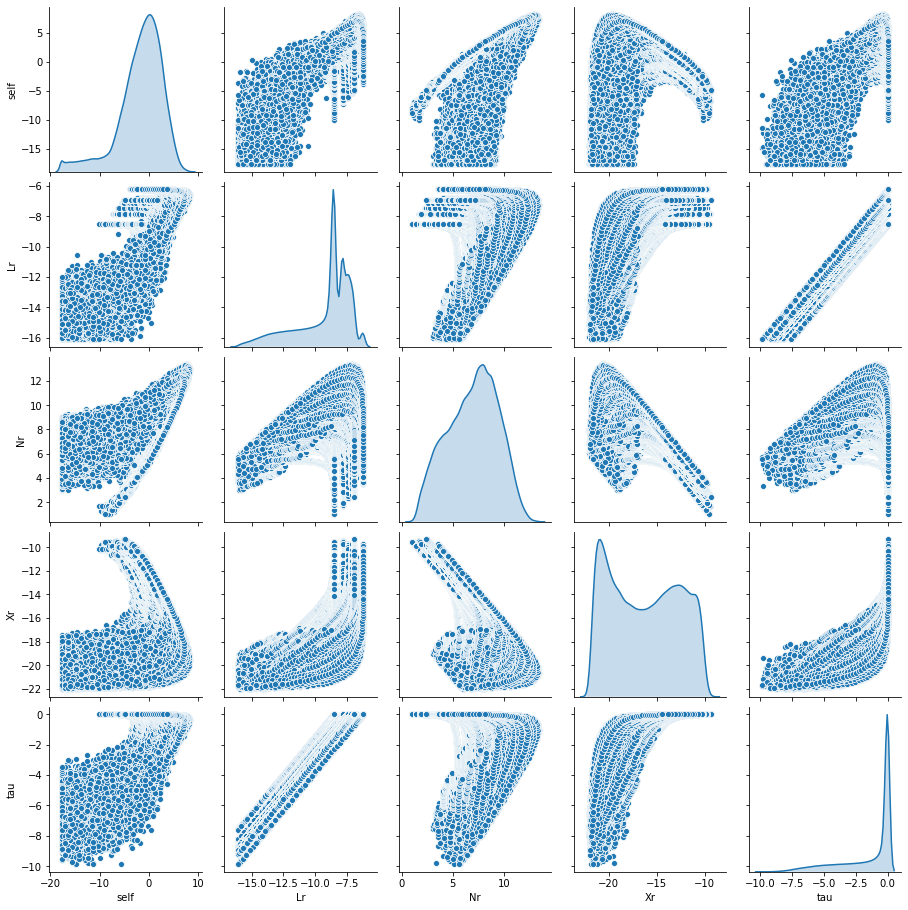

In [16]:
sns.pairplot(dataset_train[['self','Lr','Nr','Xr','tau']], diag_kind="kde")

## Separate in different dataset with selected sets of predictors

In [17]:
train_dataset0 = dataset_train.copy()
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()

test_dataset0 = dataset_test.copy()
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()

val_dataset0 = dataset_val.copy()
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()
val_dataset4 = dataset_val.copy()

In [18]:
train_dataset0 = train_dataset0.drop(['Xr','tau'], axis=1)
train_dataset1 = train_dataset1.drop(['Nr','tau'], axis=1)
train_dataset2 = train_dataset2.drop(['Lr','tau'], axis=1)
train_dataset3 = train_dataset3.drop(['Xr'], axis=1)
train_dataset4 = train_dataset4.drop(['Lr'], axis=1)

In [19]:
test_dataset0 = test_dataset0.drop(['Xr','tau'], axis=1)
test_dataset1 = test_dataset1.drop(['Nr','tau'], axis=1)
test_dataset2 = test_dataset2.drop(['Lr','tau'], axis=1)
test_dataset3 = test_dataset3.drop(['Xr'], axis=1)
test_dataset4 = test_dataset4.drop(['Lr'], axis=1)

In [20]:
val_dataset0 = val_dataset0.drop(['Xr','tau'], axis=1)
val_dataset1 = val_dataset1.drop(['Nr','tau'], axis=1)
val_dataset2 = val_dataset2.drop(['Lr','tau'], axis=1)
val_dataset3 = val_dataset3.drop(['Xr'], axis=1)
val_dataset4 = val_dataset4.drop(['Lr'], axis=1)

In [21]:
train_stats0 = train_dataset0.describe()
train_stats0.pop("self")
train_stats0 = train_stats0.transpose()
train_stats0

count      mean       std        min        25%       50%       75%  \
Lr  309151.0 -9.263053  2.144214 -16.117336 -10.272721 -8.535312 -7.830037   
Nr  309151.0  6.954503  2.428800   1.006676   5.133979  7.181265  8.808613   

          max  
Lr  -6.216760  
Nr  13.366846

In [22]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("self")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%        75%  \
Lr  309151.0  -9.263053  2.144214 -16.117336 -10.272721  -8.535312  -7.830037   
Xr  309151.0 -16.217106  3.529209 -22.034079 -19.545470 -16.254799 -13.076881   

         max  
Lr -6.216760  
Xr -9.336143

In [23]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("self")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%        75%  \
Nr  309151.0   6.954503  2.428800   1.006676   5.133979   7.181265   8.808613   
Xr  309151.0 -16.217106  3.529209 -22.034079 -19.545470 -16.254799 -13.076881   

          max  
Nr  13.366846  
Xr  -9.336143

In [24]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("self")
train_stats3 = train_stats3.transpose()
train_stats3

count      mean       std        min        25%       50%       75%  \
Lr   309151.0 -9.263053  2.144214 -16.117336 -10.272721 -8.535312 -7.830037   
Nr   309151.0  6.954503  2.428800   1.006676   5.133979  7.181265  8.808613   
tau  309151.0 -1.436393  2.085930  -9.872979  -2.399582 -0.188298 -0.011117   

           max  
Lr   -6.216760  
Nr   13.366846  
tau  -0.001000

In [25]:
train_stats4 = train_dataset4.describe()
train_stats4.pop("self")
train_stats4 = train_stats4.transpose()
train_stats4

count       mean       std        min        25%        50%  \
Nr   309151.0   6.954503  2.428800   1.006676   5.133979   7.181265   
Xr   309151.0 -16.217106  3.529209 -22.034079 -19.545470 -16.254799   
tau  309151.0  -1.436393  2.085930  -9.872979  -2.399582  -0.188298   

           75%        max  
Nr    8.808613  13.366846  
Xr  -13.076881  -9.336143  
tau  -0.011117  -0.001000

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [26]:
train_labels0 = train_dataset0.pop('self')
train_labels1 = train_dataset1.pop('self')
train_labels2 = train_dataset2.pop('self')
train_labels3 = train_dataset3.pop('self')
train_labels4 = train_dataset4.pop('self')

test_labels0  = test_dataset0.pop('self')
test_labels1  = test_dataset1.pop('self')
test_labels2  = test_dataset2.pop('self')
test_labels3  = test_dataset3.pop('self')
test_labels4  = test_dataset4.pop('self')

val_labels0  = val_dataset0.pop('self')
val_labels1  = val_dataset1.pop('self')
val_labels2  = val_dataset2.pop('self')
val_labels3  = val_dataset3.pop('self')
val_labels4  = val_dataset4.pop('self')

### Normalize the data

In [27]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data0 = norm(train_dataset0,train_stats0)
normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)
normed_train_data4 = norm(train_dataset4,train_stats4)

normed_test_data0 = norm(test_dataset0,train_stats0)
normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)
normed_test_data4 = norm(test_dataset4,train_stats4)

normed_val_data0 = norm(val_dataset0,train_stats0)
normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)
normed_val_data4 = norm(val_dataset4,train_stats4)

In [28]:
normed_train_stats0 = normed_train_data0.describe()
normed_train_stats0 = normed_train_stats0.transpose()
normed_train_stats0

count      mean       std       min       25%       50%       75%  \
Lr  309151.0  0.000139  1.000150 -3.196642 -0.470880  0.339398  0.668318   
Nr  309151.0 -0.000014  1.000031 -2.448874 -0.749557  0.093364  0.763385   

         max  
Lr  1.420704  
Nr  2.640128

In [29]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count      mean       std       min       25%       50%       75%  \
Lr  309151.0  0.000139  1.000150 -3.196642 -0.470880  0.339398  0.668318   
Xr  309151.0 -0.000033  1.000023 -1.648237 -0.943091 -0.010680  0.889781   

         max  
Lr  1.420704  
Xr  1.949718

In [30]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count      mean       std       min       25%       50%       75%  \
Nr  309151.0 -0.000014  1.000031 -2.448874 -0.749557  0.093364  0.763385   
Xr  309151.0 -0.000033  1.000023 -1.648237 -0.943091 -0.010680  0.889781   

         max  
Nr  2.640128  
Xr  1.949718

In [31]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count      mean       std       min       25%       50%       75%  \
Lr   309151.0  0.000139  1.000150 -3.196642 -0.470880  0.339398  0.668318   
Nr   309151.0 -0.000014  1.000031 -2.448874 -0.749557  0.093364  0.763385   
tau  309151.0 -0.000282  1.000242 -4.044521 -0.461755  0.598340  0.683281   

          max  
Lr   1.420704  
Nr   2.640128  
tau  0.688131

In [32]:
normed_train_stats4 = normed_train_data4.describe()
normed_train_stats4 = normed_train_stats4.transpose()
normed_train_stats4

count      mean       std       min       25%       50%       75%  \
Nr   309151.0 -0.000014  1.000031 -2.448874 -0.749557  0.093364  0.763385   
Xr   309151.0 -0.000033  1.000023 -1.648237 -0.943091 -0.010680  0.889781   
tau  309151.0 -0.000282  1.000242 -4.044521 -0.461755  0.598340  0.683281   

          max  
Nr   2.640128  
Xr   1.949718  
tau  0.688131

# The model

## Build the model

In [33]:
def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model_sigm(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "sigm":
        model = build_model_sigm(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [34]:

#activ = "tanh"
#activ = "PReLU"
#activ = "LReLU"
#activ = "ReLU"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"

activ = "sigm"

model = build_model(2,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [36]:
example_batch  = normed_train_data0[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.8586026 ],
       [-0.8586509 ],
       [-0.8585905 ],
       [-0.85843927],
       [-0.85846436],
       [-0.8584968 ],
       [-0.85851705],
       [-0.85851914],
       [-0.85854685],
       [-0.8585483 ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [39]:
# maximum number, but we use early stopping
EPOCHS = 1000

# learning rate
learn = 1e-3        # original value was 1e-3

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# for collecting the histories
histories = {}

In [40]:
model0 = build_model(len(normed_train_data0.keys()),activ,learn)

early_history0 = model0.fit(normed_train_data0, train_labels0, 
                    epochs=EPOCHS, validation_data=(normed_val_data0,val_labels0), verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:3.1186,  mae:0.9225,  mse:3.1186,  val_loss:1.8465,  val_mae:0.6544,  val_mse:1.8465,  
...........................................................................................

In [41]:
histories['Lr-Nr'] = early_history0

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

In [42]:
model1 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history1 = model1.fit(normed_train_data1, train_labels1, 
                    epochs=EPOCHS, validation_data=(normed_val_data1,val_labels1), verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:3.4212,  mae:1.0159,  mse:3.4212,  val_loss:1.9036,  val_mae:0.6894,  val_mse:1.9036,  
....................................................................................................
Epoch: 100, loss:1.7300,  mae:0.5700,  mse:1.7300,  val_loss:1.6865,  val_mae:0.5614,  val_mse:1.6865,  
...........................................................

Text(0, 0.5, 'MAE')

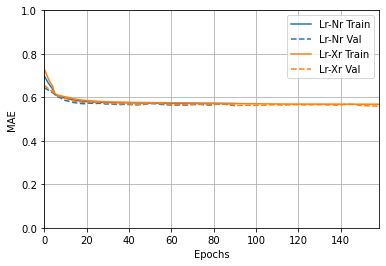

In [43]:
histories['Lr-Xr'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [44]:
model2 = build_model(len(normed_train_data2.keys()),activ,learn)

early_history2 = model2.fit(normed_train_data2, train_labels2, 
                    epochs=EPOCHS, validation_data=(normed_val_data2,val_labels2), verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:3.5346,  mae:0.9738,  mse:3.5346,  val_loss:1.8293,  val_mae:0.6351,  val_mse:1.8293,  
.....................................................................

In [45]:
histories['Nr-Xr'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

In [46]:
model3 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history3 = model3.fit(normed_train_data3, train_labels3, 
                    epochs=EPOCHS, validation_data=(normed_val_data3,val_labels3), verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:3.0740,  mae:0.8710,  mse:3.0740,  val_loss:1.9067,  val_mae:0.6431,  val_mse:1.9067,  
...........................................................................................

Text(0, 0.5, 'MAE')

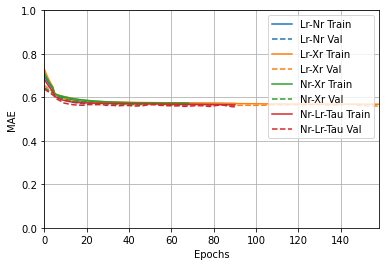

In [47]:
histories['Nr-Lr-tau'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [48]:
model4 = build_model(len(normed_train_data4.keys()),activ,learn)

early_history4 = model4.fit(normed_train_data4, train_labels4, 
                    epochs=EPOCHS, validation_data=(normed_val_data4,val_labels4), verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:3.2516,  mae:0.9127,  mse:3.2516,  val_loss:2.0481,  val_mae:0.6849,  val_mse:2.0481,  
....................................................................................................
Epoch: 100, loss:1.6969,  mae:0.5658,  mse:1.6969,  val_loss:1.6516,  val_mae:0.5548,  val_mse:1.6516,  
...............

In [49]:
histories['Nr-Xr-tau'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

Text(0, 0.5, 'MSE')

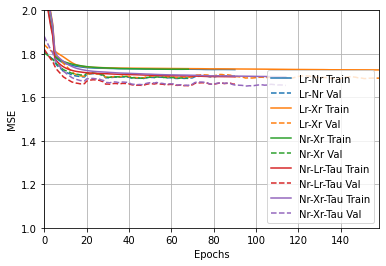

In [50]:
plotter.plot(histories, metric = "mse")
plt.ylim([1, 2])
plt.ylabel('MSE')

In [51]:
loss0, mae0, mse0 = model0.evaluate(normed_test_data0, test_labels0, verbose=2)

print("Testing set for model 0, Mean Abs Error: {:10.5f}".format(mae0))

5664/5664 - 10s - loss: 1.6148 - mae: 0.5399 - mse: 1.6148
Testing set for model 0, Mean Abs Error:    0.53991


In [52]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, test_labels1, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

5664/5664 - 10s - loss: 1.5730 - mae: 0.5356 - mse: 1.5730
Testing set for model 1, Mean Abs Error:    0.53558


In [53]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, test_labels2, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:10.5f}".format(mae2))

5664/5664 - 10s - loss: 1.6081 - mae: 0.5454 - mse: 1.6081
Testing set for model 2, Mean Abs Error:    0.54538


In [54]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, test_labels3, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:10.5f}".format(mae3))

5664/5664 - 10s - loss: 1.6066 - mae: 0.5368 - mse: 1.6066
Testing set for model 3, Mean Abs Error:    0.53681


In [55]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data4, test_labels4, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:10.5f}".format(mae4))

5664/5664 - 10s - loss: 1.5503 - mae: 0.5404 - mse: 1.5503
Testing set for model 4, Mean Abs Error:    0.54045


# Make predictions

Finally, predict the fall velocity values using data in the testing set:

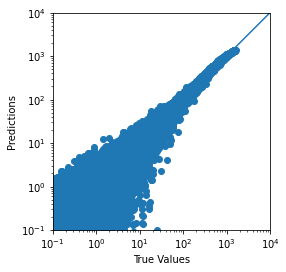

In [56]:
test_self0 = np.exp(test_labels0)
test_self1 = np.exp(test_labels1)
test_self2 = np.exp(test_labels2)
test_self3 = np.exp(test_labels3)
test_self4 = np.exp(test_labels4)

test_predict0 = np.exp(model0.predict(normed_test_data0).flatten())
test_predict1 = np.exp(model1.predict(normed_test_data1).flatten())
test_predict2 = np.exp(model2.predict(normed_test_data2).flatten())
test_predict3 = np.exp(model3.predict(normed_test_data3).flatten())
test_predict4 = np.exp(model4.predict(normed_test_data4).flatten())

amin, amax = 1e-1, 1e4

a = plt.axes(aspect='equal')
plt.scatter(test_self0, test_predict0)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

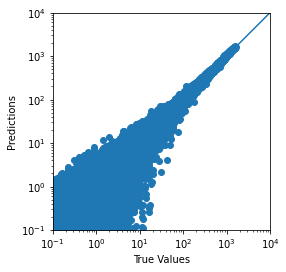

In [57]:
a = plt.axes(aspect='equal')
plt.scatter(test_self1, test_predict1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Compare with SB2001 and KK2000

In [58]:
test_dataset0.describe()

Lr             Nr
count  181247.000000  181247.000000
mean       -9.099635       7.142801
std         2.213240       2.354904
min       -16.117645       1.602635
25%       -10.201256       5.366126
50%        -8.137412       7.351242
75%        -7.606730       8.955238
max        -6.504506      12.864232

## SB2001 selfcollection rate

In [59]:
kcr = 5.78       # Long kernel in m3 kg-1 s-1 
kcc = 9.44e9      # Long kernel in m3 kg-2 s-1 

qr  = np.exp(np.array(test_dataset0.Lr))
nr  = np.exp(np.array(test_dataset0.Nr))

selfSB = kcr * qr * nr

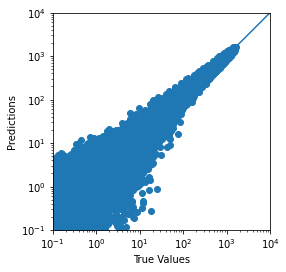

In [60]:
test_predict_sb = selfSB

a = plt.axes(aspect='equal')
plt.scatter(test_self1, test_predict_sb)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Final statistics 

In [61]:
self0 = test_predict0
self1 = test_predict1
self2 = test_predict2
self3 = test_predict3
self4 = test_predict4

selfTruth = test_self0

In [62]:
np.max(selfTruth)

1643.939697265625

In [63]:
def mean_abs_error(var, varTrue):  
    return np.mean(np.abs(var - varTrue))

def mean_sqr_error(var, varTrue):    
    return np.sqrt(np.mean((var - varTrue)**2))                   

In [64]:
mae0 = mean_abs_error(self0,test_self0)
mae1 = mean_abs_error(self1,test_self1)
mae2 = mean_abs_error(self2,test_self2)
mae3 = mean_abs_error(self3,test_self3)
mae4 = mean_abs_error(self4,test_self4)
maeSB = mean_abs_error(selfSB,selfTruth)

mse0 = mean_sqr_error(self0,test_self0)
mse1 = mean_sqr_error(self1,test_self1)
mse2 = mean_sqr_error(self2,test_self2)
mse3 = mean_sqr_error(self3,test_self3)
mse4 = mean_sqr_error(self4,test_self4)
mseSB = mean_sqr_error(selfSB,selfTruth)

mae = [ mae0, mae1, mae2, mae3, mae4, maeSB ] #, maeSB2, maeKK, maePwr ]
mse = [ mse0, mse1, mse2, mse3, mse4, mseSB ] #, mseSB2, mseKK, msePwr ]

In [65]:
mae

[1.3438409566879272,
 1.1780229806900024,
 1.5123002529144287,
 1.3841463327407837,
 1.3710194826126099,
 2.1316003799438477]

In [66]:
mse

[6.013639523703173,
 4.382697608788236,
 6.674824618775107,
 7.26336831763521,
 6.847513914397059,
 8.861230618884417]

In [67]:
labels = list(histories.keys())
labels.append('SB2001')
labels

['Lr-Nr', 'Lr-Xr', 'Nr-Xr', 'Nr-Lr-tau', 'Nr-Xr-tau', 'SB2001']

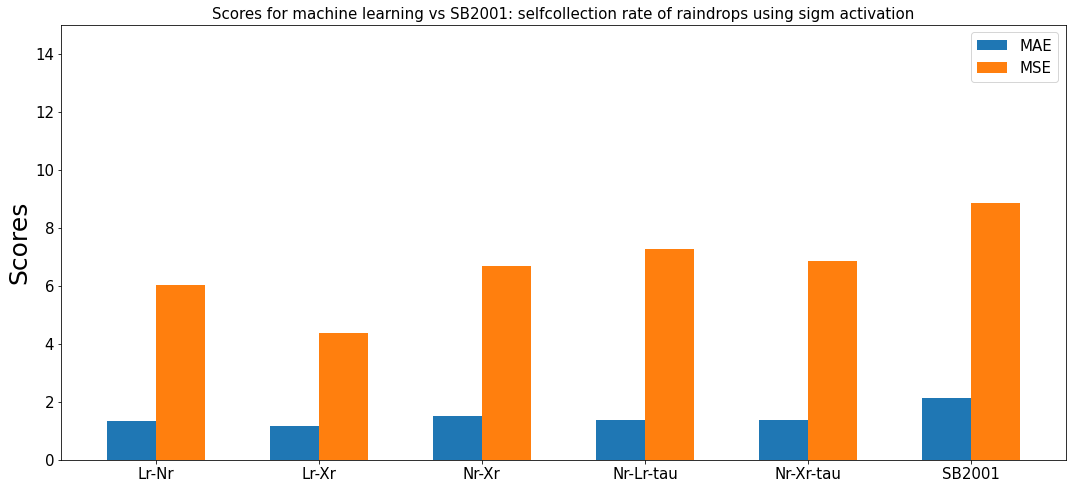

In [68]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae, width, label='MAE')
rects2 = ax.bar(x + width/2, mse, width, label='MSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for machine learning vs SB2001: selfcollection rate of raindrops using '+activ+' activation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,15)
ax.legend()

#fig.tight_layout()

plt.show()



In [69]:
fig.savefig("selfRain_barplot_v9_01_"+activ+"_eps15.png", bbox_inches='tight', dpi=600)

# Save models and normalization

In [70]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v9

model0.save('saved_model_v9/selfrain_01_LrNr_'+activ+'_16x16x16_'+data) 
model1.save('saved_model_v9/selfrain_01_LrXr_'+activ+'_16x16x16_'+data) 
model2.save('saved_model_v9/selfrain_01_NrXr_'+activ+'_16x16x16_'+data) 
model3.save('saved_model_v9/selfrain_01_NrLrTau_'+activ+'_16x16x16_'+data) 
model4.save('saved_model_v9/selfrain_01_NrXrTau_'+activ+'_16x16x16_'+data) 

# save train_stats for normalization of input data in Pandas pickle format
train_stats0.to_pickle('saved_model_v9/selfrain_01_LrNr_'+activ+'_16x16x16_'+data+'_norm.pickle')
train_stats1.to_pickle('saved_model_v9/selfrain_01_LrXr_'+activ+'_16x16x16_'+data+'_norm.pickle')
train_stats2.to_pickle('saved_model_v9/selfrain_01_NrXr_'+activ+'_16x16x16_'+data+'_norm.pickle')
train_stats3.to_pickle('saved_model_v9/selfrain_01_NrLrTau_'+activ+'_16x16x16_'+data+'_norm.pickle')
train_stats4.to_pickle('saved_model_v9/selfrain_01_NrXrTau_'+activ+'_16x16x16_'+data+'_norm.pickle')



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model_v9/selfrain_01_LrNr_sigm_16x16x16_big_n5/assets
INFO:tensorflow:Assets written to: saved_model_v9/selfrain_01_LrXr_sigm_16x16x16_big_n5/assets
INFO:tensorflow:Assets written to: saved_model_v9/selfrain_01_NrXr_sigm_16x16x16_big_n5/assets
INFO:tensorflow:Assets written to: saved_model_v9/selfrain_01_NrLrTau_sigm_16x16x16_big_n5/assets
INFO:tensorflow:Assets written to: saved_model_v9/selfrain_01_NrXrTau_sigm_16x16x16_big_n5/assets


In [71]:
normed_train_data1.to_csv('selfrain_01_normed_train_data1.csv', index=False)
normed_val_data1.to_csv('selfrain_01_normed_val_data1.csv', index=False)
normed_test_data1.to_csv('selfrain_01_normed_test_data1.csv', index=False)
train_labels1.to_csv('selfrain_01_train_labels1.csv', index=False)
val_labels1.to_csv('selfrain_01_val_labels1.csv', index=False)
test_labels1.to_csv('selfrain_01_test_labels1.csv', index=False)